# Import Modules

In [1]:
import numpy as np
from matplotlib import pyplot as plt
import PIL
from pathlib import Path
import pandas as pd
import copy
%matplotlib inline

# Structure Design

## Activation Functions Definition

In [2]:
def sigmoid(z):
    # negative_overflow = np.where(z<=-709, 0, 0)
    okay_range = np.where((-709<z)&(z<709), 1/(1 + np.exp(-z)), 0)
    positive_overflow = np.where(z>=709, 1, 0)
    return okay_range + positive_overflow

def sigmoid_derivative(z):
    return sigmoid(z)*(1-sigmoid(z))


def relu(z, leak_grad=0):
    return np.maximum(leak_grad*z, z)


def relu_derivative(z, leak_grad=0):
    return np.where(z <= 0, leak_grad, 1)


def tanh(z):
    return (np.exp(z) - np.exp(-z)) / (np.exp(z) + np.exp(-z))


def tanh_derivative(z):
    return 1 - tanh(z)**2


def softmax(Z, epsilon=1e-8):
    Z = Z - np.max(Z)
    exp_Z = np.exp(Z)
    return exp_Z / (np.sum(exp_Z, axis=0)+epsilon)

# def softmax_derivative(Z):
#     return 1

def identity(Z):
    return Z

def identity_derivative(Z):
    return 1

In [3]:
activation_functions_dict = {'sigmoid': (sigmoid, sigmoid_derivative),
                             'relu': (relu, relu_derivative),
                             'tanh': (tanh, tanh_derivative),
                             'softmax': (softmax, None),
                             'identity': (identity, identity_derivative)}

## Layer Namespace Definition

In [4]:
class LayerNamespace(object):
    pass

## Structure Class Definition

In [5]:
class ModelStructure(object):
    def __init__(self):
        self.__layers = []

    def add_input_layer(self, input_features: int):
        assert len(self.__layers) == 0, 'Add input layer before other layers'
        assert type(input_features) == int, 'Enter integer number'
        layer_0 = LayerNamespace()
        layer_0.units_number = input_features
        self.__layers.append(layer_0)

    def add_layer(self, units_number: int, activation_function_name='identity',
                  keep_prob=1):
        assert type(units_number) == int, 'Enter integer number'
        assert len(self.__layers) > 0, 'First add input layer'

        try:
            layer = LayerNamespace()
            valid_key = activation_function_name.lower()
            layer.activation_function = activation_functions_dict[valid_key][0]
            layer.activation_function_derivative = activation_functions_dict[valid_key][1]
            layer.units_number = units_number
            layer.keep_prob = keep_prob
            self.__layers.append(layer)
        except KeyError as error:
            message = 'Valid activation functions: '
            message += ', '.join(activation_functions_dict.keys())
            raise KeyError(f'{error} ({message})')

        return True

    @property
    def layers(self):
        assert len(self.__layers) > 1, 'At least nsert one layer'
        return self.__layers

    def summary(self):
        print(f'Input Features: {self.layers[0].units_number}')
        total_parameters = 0
        pre_units = self.layers[0].units_number
        for i, layer in enumerate(self.layers[1:]):
            weights = layer.units_number * pre_units
            biases = layer.units_number
            message_parts = [f'Layer #{i+1}:',
                             f'{layer.units_number}',
                             f'{layer.activation_function.__name__}',
                             f'units with {weights} weights and',
                             f'{biases} biases']
            print(' '.join(message_parts))
            pre_units = layer.units_number
            total_parameters += (weights+biases)
        print(f'Total Parameters: {total_parameters}')

# Computation

## Tools

### Initializer

In [6]:
def initialize(layers: list):
    result = []
    previous_layer = layers[0]
    for layer in layers[1:]:
        shape = (layer.units_number,
                 previous_layer.units_number)
        # On weight initialization in deep neural networks
        scale_dict = {'relu': np.sqrt(2/shape[1]),
                      'tanh': np.sqrt(1/shape[1]),
                      'sigmoid': np.sqrt((3.6**2)/shape[1]),
                      'softmax': np.sqrt(2/shape[1]),
                      'identity': np.sqrt(2/shape[1])}
        func_name = layer.activation_function.__name__
        layer.W = np.random.randn(
            shape[0], shape[1]) * scale_dict[func_name]

        layer.b = np.zeros((shape[0], 1))
        result.append(layer)
        previous_layer = layer
    return result

### Mini Batch Generator

In [7]:
def mini_batch_generator(x: np.ndarray, y: np.ndarray, batch_size: int):
    assert x.shape[1] == y.shape[1]
    m = x.shape[1]
    random_indice = np.random.permutation(m)
    shuffled_x = x[:, random_indice]
    shuffled_y = y[:, random_indice]

    div = divmod(m, batch_size)
    for i in range(div[0]):
        x_mini_batch = shuffled_x[:, i*batch_size:(i+1)*batch_size]
        x_mini_batch = x_mini_batch.reshape(x.shape[0], batch_size)

        y_mini_batch = shuffled_y[:, i*batch_size:(i+1)*batch_size]
        y_mini_batch = y_mini_batch.reshape(y.shape[0], batch_size)

        yield x_mini_batch, y_mini_batch

    if div[1]:
        x_mini_batch = shuffled_x[:, div[0]*batch_size:]
        x_mini_batch = x_mini_batch.reshape(x.shape[0], div[1])

        y_mini_batch = shuffled_y[:, div[0]*batch_size:]
        y_mini_batch = y_mini_batch.reshape(y.shape[0], div[1])

        yield x_mini_batch, y_mini_batch

### Metric Calculators

In [8]:
 def get_predict_function(apply_softmax=True):   
 
    def predict(model_output):
        prediction = np.where(model_output > 0.5, 1, 0)
        return prediction

    def softmax_predict(Z):
        A = softmax(Z)
        return predict(A)

    if apply_softmax:
        return softmax_predict
    else:
        return predict

def get_accuracy_function(binary=False):
    def binary_accuracy(prediction, expected):
        assert prediction.shape == expected.shape
    #     assert prediction.shape[0] == 1
        m = expected.shape[1]
        accuracy = np.sum(prediction == expected)/m
        return accuracy

    def categorical_accuracy(prediction, expected):
        assert prediction.shape == expected.shape
        assert prediction.shape[0] != 1
        m = expected.shape[1]
        accuracy = np.sum(np.argmax(prediction, axis=0) == np.argmax(expected, axis=0))/m
        return accuracy

    if binary:
        return binary_accuracy
    else: 
        return categorical_accuracy

### Metric Visualization

In [9]:
def print_metrics(interval=100):
    def result_function(metrics):
        epoch = metrics['total_trained_epochs']
        if (epoch == 1) or (epoch % interval == 0):
            cost = metrics['costs'][-1]
            accuracy = metrics['accuracies'][-1]*100
            message_parts = [f'Epoch #{epoch:0>4}',
                             f'Cost: {cost:.4f}',
                             f'Accuracy: {accuracy:.2f}%']

            if metrics['validation_costs']:
                validation_cost = metrics['validation_costs'][-1]
                validation_accuracy = metrics['validation_accuracies'][-1]*100
                message_parts.append(
                    f'Validation Cost: {validation_cost:.4f}')
                message_parts.append(
                    f'Validation Accuracy: {validation_accuracy:.2f}%')

            print(' | '.join(message_parts))
    return result_function

In [10]:
def plot_metrics(metrics: dict, interval=100):
    cost = metrics['costs']
    accuracy = metrics['accuracies']
    validation_cost = metrics['validation_costs']
    validation_accuracies = metrics['validation_accuracies']

    fig, axes = plt.subplots(2, 1, constrained_layout=True)

    axes[0].plot(cost[::interval], label='Training Cost')
    axes[0].plot(validation_cost[::interval], label='Validation Cost')
    axes[0].set_ylabel('epoch')
    axes[0].set_ylabel('Cost')
    axes[0].legend()

    axes[1].plot(accuracy[::interval], label='Training Accuracy')
    axes[1].plot(validation_accuracies[::interval],
                 label='Validation Accuracy')
    axes[1].set_ylabel('epoch')
    axes[1].set_ylabel(f'Accuracy')
    axes[1].legend()

    # fig.tight_layout(pad=0, w_pad=0, h_pad=0)
    fig.set_size_inches(12, 9)
    plt.show()
    return fig

## Cost Functions

In [11]:
def get_cross_entropy_cost_function(binary=False):  
    def binary_cross_entropy(Y, Y_hat, epsilon=1e-4):
        assert Y.shape == Y_hat.shape, f'{Y.shape} != {Y_hat.shape}'
        m = Y.shape[1]  # number of examples
        cost = (-1/m) * (np.dot(Y, np.log(Y_hat+epsilon).T) +
                        np.dot((1-Y), np.log(1-Y_hat+epsilon).T))
        return cost.item()


    def binary_cross_entropy_derivative(Y, Y_hat, epsilon=1e-4):
        return ((1-Y)/(1-Y_hat+epsilon)) - (Y/(Y_hat+epsilon))

    def softmax_crossentropy(Y, Y_hat, epsilon=1e-4):
        assert Y.shape == Y_hat.shape, f'{Y.shape} != {Y_hat.shape}'
        Y_hat = softmax(Y_hat)
        m = Y.shape[1]
        cost = 1/m * np.sum(-np.sum(Y*np.log(Y_hat+epsilon), axis=0))
        return cost

    def softmax_crossentropy_derivative(Y, Y_hat, epsilon=1e-7):
        Y_hat = softmax(Y_hat)
        return Y_hat-Y

    if binary:
        return binary_cross_entropy, binary_cross_entropy_derivative
    else:
        return softmax_crossentropy, softmax_crossentropy_derivative
    
def get_regularization_cost(layers: list, m: int, lambda_: float) -> float:
    cost = 0
    for layer in layers:
        cost += np.sum(np.square(layer.W))
    cost *= (1/m) * (lambda_/2)
    return cost

## Optimizers

### Optimizer Superclass

In [12]:
class Optimizer(object):
    def initiate_parameters(self, layers: list):
        pass
    def update_parameters(self, layers: list):
        pass
    def update_optimizer(self, metrics: dict):
        pass

### Gradient Descent

In [13]:
class GradientDescent(Optimizer):
    def __init__(self, learning_rate):
        self.learning_rate = learning_rate
        
    def update_parameters(self, layers: list):
        for layer in layers:
            layer.W = layer.W - self.learning_rate*layer.dW
            layer.b = layer.b - self.learning_rate*layer.db
        return True

### Momentum

In [14]:
class Momentum(Optimizer):
    def __init__(self, learning_rate, beta):
        self.learning_rate = learning_rate
        self.beta = beta

    def initiate_parameters(self, layers: list):
        for layer in layers:
            layer.V_dW = np.zeros(layer.W.shape)
            layer.V_db = np.zeros(layer.b.shape)
        return True
            
    def update_parameters(self, layers: list):
        for layer in layers:            
            layer.V_dW = self.beta*layer.V_dW + (1-self.beta)*layer.dW
            layer.V_db = self.beta*layer.V_db + (1-self.beta)*layer.db
            
            layer.W = layer.W - self.learning_rate*layer.V_dW
            layer.b = layer.b - self.learning_rate*layer.V_db
        return True

### RMSprop

In [15]:
class RMSprop(Optimizer):
    def __init__(self, learning_rate, beta=0.9):
        self.learning_rate = learning_rate
        self.beta = beta
        self.epsilon = 1e-8

    def initiate_parameters(self, layers: list):
        for layer in layers:
            layer.S_dW = np.zeros(layer.W.shape)
            layer.S_db = np.zeros(layer.b.shape)
        return True
            
    def update_parameters(self, layers: list):
        for layer in layers:            
            layer.S_dW = self.beta*layer.S_dW + (1-self.beta)*np.square(layer.dW)
            layer.S_db = self.beta*layer.S_db + (1-self.beta)*np.square(layer.db)
            
            layer.W = layer.W - self.learning_rate*(layer.dW/(np.sqrt(layer.S_dW)+self.epsilon))
            layer.b = layer.b - self.learning_rate*(layer.db/(np.sqrt(layer.S_db)+self.epsilon))
        return True

### Adam

In [16]:
class Adam(Optimizer):
    def __init__(self, learning_rate=0.001, beta_1=0.9, beta_2=0.999):
        self.learning_rate = learning_rate
        self.beta_1 = beta_1
        self.beta_2 = beta_2
        self.epsilon = 1e-7
        self.counter = 0

    def initiate_parameters(self, layers: list):
        self.counter = 0
        for layer in layers:
            layer.V_dW = np.zeros(layer.W.shape)
            layer.V_db = np.zeros(layer.b.shape)
            layer.S_dW = np.zeros(layer.W.shape)
            layer.S_db = np.zeros(layer.b.shape)
            
            layer.V_corrected_dW = np.zeros(layer.W.shape)
            layer.V_corrected_db = np.zeros(layer.b.shape)
            layer.S_corrected_dW = np.zeros(layer.W.shape)
            layer.S_corrected_db = np.zeros(layer.b.shape)
        return True
            
    def update_parameters(self, layers: list):
        for layer in layers:            
            layer.V_dW = self.beta_1*layer.V_dW + (1-self.beta_1)*layer.dW
            layer.V_db = self.beta_1*layer.V_db + (1-self.beta_1)*layer.db
            layer.S_dW = self.beta_2*layer.S_dW + (1-self.beta_2)*np.square(layer.dW)
            layer.S_db = self.beta_2*layer.S_db + (1-self.beta_2)*np.square(layer.db)
            
            # Apply bias correction
            momentum_correction = 1/(1-self.beta_1**(self.counter+1))
            rmsprop_correction = 1/(1-self.beta_2**(self.counter+1))

            layer.V_corrected_dW = layer.V_dW*momentum_correction
            layer.V_corrected_db = layer.V_db*momentum_correction
            layer.S_corrected_dW = layer.S_dW*rmsprop_correction
            layer.S_corrected_db = layer.S_db*rmsprop_correction
        
            layer.W = layer.W - self.learning_rate*(layer.V_corrected_dW/(np.sqrt(layer.S_corrected_dW)+self.epsilon))
            layer.b = layer.b - self.learning_rate*(layer.V_corrected_db/(np.sqrt(layer.S_corrected_db)+self.epsilon))
        self.counter += 1
        return True

### Mechanic Rules

In [17]:
class MechanicRules(Optimizer):
    def __init__(self, learning_rate, g=9.81):
        self.learning_rate = learning_rate
        self.g = g
        self.epsilon = 1e-8

    def initiate_parameters(self, layers: list):
        for layer in layers:
            layer.v_hat_W = np.zeros(layer.W.shape)
            layer.v_hat_b = np.zeros(layer.b.shape)
            
            layer.a_hat_W = np.zeros(layer.W.shape)
            layer.a_hat_b = np.zeros(layer.b.shape)
        return True
            
    def update_parameters(self, layers: list):
        for layer in layers:
            s_W = 1 / (np.sqrt(1+np.square(layer.dW))+self.epsilon)
            s_b = 1 / (np.sqrt(1+np.square(layer.db))+self.epsilon)
            
            layer.W = (-0.5*(self.g*layer.dW*s_W + layer.a_hat_W)*(self.learning_rate**2) + layer.v_hat_W*self.learning_rate + layer.W)*s_W
            layer.b = (-0.5*(self.g*layer.db*s_b + layer.a_hat_b)*(self.learning_rate**2) + layer.v_hat_b*self.learning_rate + layer.b)*s_b
            
            layer.v_hat_W = -(self.g*layer.dW*s_W+layer.a_hat_W)*self.learning_rate + layer.v_hat_W
            layer.v_hat_b = -(self.g*layer.db*s_b+layer.a_hat_b)*self.learning_rate + layer.v_hat_b
        return True

### Gravity

In [18]:
class Gravity(Optimizer):
    def __init__(self, learning_rate, g=9.81):
        self.learning_rate = learning_rate
        self.g = -g
        self.epsilon = 1e-8
        self.update_counter = 0
        self.learning_rate_history = {0: learning_rate}

    def initiate_parameters(self, layers: list):
        for layer in layers:
            layer.v_W = np.zeros(layer.W.shape)
            layer.v_b = np.zeros(layer.b.shape)
        return True
            
    def update_parameters(self, layers: list):
        for layer in layers:
            c_W = layer.dW / (1+np.square(layer.dW)+self.epsilon)            
            layer.v_W = self.g*c_W*self.learning_rate + layer.v_W
            c_b = layer.db / (1+np.square(layer.db)+self.epsilon)
            layer.v_b = self.g*c_b*self.learning_rate + layer.v_b  
            
            layer.W = self.learning_rate*layer.v_W + layer.W
            layer.b = self.learning_rate*layer.v_b + layer.b
            self.update_counter += 1
        return True
    def update_optimizer(self, metrics: dict):
        metrics['learning_rate'].append(self.learning_rate)
        metrics['g'].append(self.g)
        return metrics


In [19]:
class Gravity2(Optimizer):
    def __init__(self, learning_rate, g=9.81):
        self.learning_rate = learning_rate
        self.g = -g
        self.epsilon = 1e-8
        self.update_counter = 0
        self.learning_rate_history = {0: learning_rate}

    def initiate_parameters(self, layers: list):
        for layer in layers:
            layer.v_W = np.zeros(layer.W.shape)
            layer.v_b = np.zeros(layer.b.shape)
        return True
            
    def update_parameters(self, layers: list):
        for layer in layers:
            c_W = layer.dW / (1+np.square(layer.dW)+self.epsilon)
            v_W_correct = np.where(layer.dW>0, -1, 1)*np.absolute(layer.v_W)         
            layer.v_W = self.g*c_W*self.learning_rate + v_W_correct

            c_b = layer.db / (1+np.square(layer.db)+self.epsilon)
            v_b_correct = np.where(layer.db>0, -1, 1)*np.absolute(layer.v_b)
            layer.v_b = self.g*c_b*self.learning_rate + v_b_correct
            
            layer.W = self.learning_rate*layer.v_W + layer.W
            layer.b = self.learning_rate*layer.v_b + layer.b
            self.update_counter += 1
        return True
    def update_optimizer(self, metrics: dict):
        pass


In [20]:
class Gravity3(Optimizer):
    def __init__(self, learning_rate, beta=0.9, g=10):
        self.learning_rate = learning_rate
        self.beta = beta
        self.epsilon = 1e-8
        self.g=g

    def initiate_parameters(self, layers: list):
        for layer in layers:
            layer.v_W = np.zeros(layer.W.shape)
            layer.v_b = np.zeros(layer.b.shape)
        return True
            
    def update_parameters(self, layers: list):
        for layer in layers:
            c_W = layer.dW / (1+np.square(layer.dW)+self.epsilon)
            v_W_correct = np.where(layer.dW>0, -1, 1)*np.absolute(layer.v_W)         
            layer.v_W = -self.beta*c_W*self.g*self.learning_rate + (1-self.beta)*v_W_correct

            c_b = layer.db / (1+np.square(layer.db)+self.epsilon)
            v_b_correct = np.where(layer.db>0, -1, 1)*np.absolute(layer.v_b)
            layer.v_b = -self.beta*c_b*self.g*self.learning_rate + (1-self.beta)*v_b_correct
            
            layer.W = self.learning_rate*layer.v_W + layer.W
            layer.b = self.learning_rate*layer.v_b + layer.b
        return True
    def update_optimizer(self, metrics: dict):
        pass


### Courant

In [21]:
class Courant(Optimizer):
    def __init__(self, g=9.81, courant_max=0.01, sine_mode=False, mu=0):
        self.g = -g
        self.epsilon = 1e-8
        self.update_counter = 0
        self.courant_max = courant_max
        self.sine_mode = 1 if sine_mode else 0
        self.mu = mu

    def initiate_parameters(self, layers: list):
        for layer in layers:
            layer.v_W = np.zeros(layer.W.shape)
            layer.v_b = np.zeros(layer.b.shape)
            layer.dt_W = np.random.rand(*layer.W.shape)
            layer.dt_b = np.random.rand(*layer.b.shape)
        return True
            
    def update_parameters(self, layers: list):
        for layer in layers:
            c_W = (layer.dW-self.mu) / (1+np.square(layer.dW)+self.epsilon)            
            layer.v_W = self.g*c_W* layer.dt_W + layer.v_W
            dx_W_num = np.absolute(layer.dW)**self.sine_mode
            dx_W_denom = np.sqrt(1+np.square(layer.dW) + self.epsilon)
            dx_W = dx_W_num/dx_W_denom
            layer.dt_W = (self.courant_max*dx_W) / (np.absolute(layer.v_W)+self.epsilon)

            c_b = (layer.db-self.mu) / (1+np.square(layer.db)+self.epsilon)            
            layer.v_b = self.g*c_b* layer.dt_b + layer.v_b
            dx_b_num = np.absolute(layer.db)**self.sine_mode
            dx_b_denom = np.sqrt(1+np.square(layer.db) + self.epsilon)
            dx_b = dx_b_num / dx_b_denom
            layer.dt_b = (self.courant_max*dx_b) / (np.absolute(layer.v_b)+self.epsilon) 
            
            layer.W = layer.dt_W*layer.v_W + layer.W
            layer.b = layer.dt_b*layer.v_b + layer.b
            self.update_counter += 1
        return True
    def update_optimizer(self, metrics: dict):
        pass

In [22]:
class Courant2(Optimizer):
    def __init__(self, beta=0.9, courant_max=0.01, sine_mode=False, mu=0):
        self.beta = beta
        self.epsilon = 1e-8
        self.update_counter = 0
        self.courant_max = courant_max
        self.sine_mode = 1 if sine_mode else 0
        self.mu = mu

    def initiate_parameters(self, layers: list):
        for layer in layers:
            layer.v_W = np.zeros(layer.W.shape)
            layer.v_b = np.zeros(layer.b.shape)
            layer.dt_W = np.random.rand(*layer.W.shape)
            layer.dt_b = np.random.rand(*layer.b.shape)
        return True
            
    def update_parameters(self, layers: list):
        for layer in layers:
            c_W = (layer.dW-self.mu) / (1+np.square(layer.dW)+self.epsilon)
            v_W_correct = np.where(layer.dW>0, -1, 1)*np.absolute(layer.v_W)   
            layer.v_W = -self.beta*c_W* layer.dt_W + (1-self.beta)*v_W_correct
            dx_W_num = np.absolute(layer.dW)**self.sine_mode
            dx_W_denom = np.sqrt(1+np.square(layer.dW) + self.epsilon)
            dx_W = dx_W_num/dx_W_denom
            layer.dt_W = (self.courant_max*dx_W) / (np.absolute(layer.v_W)+self.epsilon)

            c_b = (layer.db-self.mu) / (1+np.square(layer.db)+self.epsilon)
            v_b_correct = np.where(layer.db>0, -1, 1)*np.absolute(layer.v_b)          
            layer.v_b = -self.beta*c_b* layer.dt_b + (1-self.beta)*v_b_correct
            dx_b_num = np.absolute(layer.db)**self.sine_mode
            dx_b_denom = np.sqrt(1+np.square(layer.db) + self.epsilon)
            dx_b = dx_b_num / dx_b_denom
            layer.dt_b = (self.courant_max*dx_b) / (np.absolute(layer.v_b)+self.epsilon) 
            
            layer.W = layer.dt_W*layer.v_W + layer.W
            layer.b = layer.dt_b*layer.v_b + layer.b
            self.update_counter += 1
        return True
    def update_optimizer(self, metrics: dict):
        pass

## Main Model Class

In [23]:
class Classifier(object):
    def __init__(self, model_structure: ModelStructure, binary=False):
        self.input_features = model_structure.layers[0].units_number
        self.layers = initialize(model_structure.layers)
        self.layers_backup = copy.deepcopy(self.layers)
        self.cost_function = get_cross_entropy_cost_function(binary=binary)[0]
        self.cost_function_derivative = get_cross_entropy_cost_function(binary=binary)[1]
        self.accuracy_func = get_accuracy_function(binary=binary)
        self.predict_function = get_predict_function(apply_softmax=not binary)
        self.metrics = {
                        'costs': [],
                        'accuracies': [],
                        'validation_costs': [],
                        'validation_accuracies': [],
                        'total_trained_epochs': 0,
                        'current_trained_epochs': 0,
                        }

    def undo_update(self):
        self.layers = copy.deepcopy(self.layers_backup)
        self.metrics['costs'].pop()
        self.metrics['accuracies'].pop()
        self.metrics['validation_costs'].pop()
        self.metrics['validation_accuracies'].pop()
        self.metrics['total_trained_epochs'] -= 1
        self.metrics['current_trained_epochs'] -= 1
        print('Last Successful Parameters Recovered')

    def feed_forward(self, X: np.ndarray):
        assert X.shape[0] == self.input_features
        A_prev = X
        for layer in self.layers:
            Z = np.dot(layer.W, A_prev) + layer.b
            A = layer.activation_function(Z)
            A_prev = A
        Y_hat = A_prev
        return Y_hat

    def feed_forward_train(self, X: np.ndarray):
        assert X.shape[0] == self.input_features
        A_prev = X
        for layer in self.layers:
            layer.A_previous = A_prev
            layer.Z = np.dot(layer.W, A_prev) + layer.b
            A_raw = layer.activation_function(
                layer.Z)  # Before applying dropout
            layer.D = np.random.rand(
                *A_raw.shape) < layer.keep_prob  # Dropout Mask
            layer.A = (A_raw * layer.D) / layer.keep_prob
            A_prev = layer.A
        Y_hat = A_prev
        return Y_hat

    def back_propagate(self, cost_derivative, lambda_):
        dA_prev = cost_derivative
        m = self.layers[0].Z.shape[1]  # number of examples
        for layer in self.layers[::-1]:
            layer.dA = (dA_prev*layer.D) / layer.keep_prob
            layer.dZ = layer.dA * layer.activation_function_derivative(layer.Z)
            layer.dW = (1/m) * np.dot(layer.dZ,
                                      layer.A_previous.T) + (lambda_/m)*layer.W
            layer.db = 1/m * np.sum(layer.dZ, axis=1, keepdims=True)
            dA_prev = np.dot(layer.W.T, layer.dZ)
        return True

    def fit_minibatch(self, mini_X, mini_Y, lambda_, optimizer):
        mini_Y_hat = self.feed_forward_train(mini_X)
        cost_derivative = self.cost_function_derivative(mini_Y, mini_Y_hat)
        self.back_propagate(cost_derivative, lambda_)
        optimizer.update_parameters(self.layers)
        return True

    def fit(self, X, Y, epochs, batch_size, optimizer,
            lambda_=0,
            validation_data=None,
            metrics_printer=None):
        
        # Assert Shapes
        assert X.shape[1] == Y.shape[1]        
        m = X.shape[1]
        if validation_data:
            assert type(validation_data) == tuple
            assert type(validation_data[0]) == np.ndarray
            assert type(validation_data[1]) == np.ndarray
            assert validation_data[0].shape[0] == X.shape[0]
            assert validation_data[1].shape[0] == Y.shape[0]
            assert validation_data[0].shape[1] == validation_data[1].shape[1]

        self.metrics['current_trained_epochs'] = 0
        optimizer.initiate_parameters(self.layers)
        for _ in range(1, epochs+1):
            self.layers_backup = copy.deepcopy(self.layers)           
            mini_batchs = mini_batch_generator(X, Y, batch_size)
            for mini_X, mini_Y in mini_batchs:
                self.fit_minibatch(mini_X, mini_Y, lambda_, optimizer)

            regularization_cost = get_regularization_cost(self.layers, m,
                                                          lambda_)

            train_Y_hat = self.feed_forward(X)
            train_cost = self.cost_function(Y, train_Y_hat)
            train_cost += regularization_cost
            train_prediction = self.predict_function(train_Y_hat)
            train_accuracy = self.accuracy_func(train_prediction, Y)
            self.metrics['costs'].append(train_cost)
            self.metrics['accuracies'].append(train_accuracy)

            if validation_data:
                validation_X = validation_data[0]
                validation_Y = validation_data[1]
                validation_Y_hat = self.feed_forward(validation_X)
                validation_cost = self.cost_function(validation_Y,
                                                     validation_Y_hat) 
                validation_cost += regularization_cost
                validation_prediction = self.predict_function(validation_Y_hat)
                validation_accuracy = self.accuracy_func(validation_prediction,
                                                         validation_Y)
                self.metrics['validation_costs'].append(validation_cost)
                self.metrics['validation_accuracies'].append(validation_accuracy)

            self.metrics['total_trained_epochs'] += 1
            self.metrics['current_trained_epochs'] += 1

            if metrics_printer:
                metrics_printer(self.metrics)
                         
            optimizer.update_optimizer(self.metrics)            
        return self.metrics

# MNIST

In [24]:
def get_dataset(dataset_path):
    data = np.load(dataset_path)
    X_train = data['X_train']
    Y_train = data['Y_train']
    X_test = data['X_test']
    Y_test = data['Y_test']
    return X_train, Y_train, X_test, Y_test

In [25]:
def one_hot_encode(Y, C):
    assert Y.ndim == 1
    m = Y.shape[0]
    shape = (C, m)
    result = np.zeros(shape)
    result[Y,np.arange(m)] = 1
    return result

In [26]:
mnist_path = Path.joinpath(Path('datasets'), Path('mnist.npz'))
X_train, Y_train, X_test, Y_test = get_dataset(mnist_path)

In [27]:
X_train = X_train.reshape(X_train.shape[0], -1).T
X_test = X_test.reshape(X_test.shape[0], -1).T
Y_train = one_hot_encode(Y_train, 10)
Y_test = one_hot_encode(Y_test, 10)

[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]


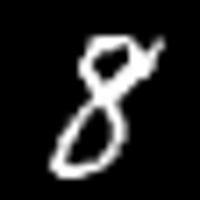

In [28]:
index = 85
print(Y_train[:,index])
PIL.Image.fromarray(X_train[:, index].reshape(28, 28)).resize((200, 200))

In [29]:
X_train = X_train / 255
X_test = X_test / 255

In [30]:
structure = ModelStructure()
structure.add_input_layer(X_train.shape[0])
structure.add_layer(128, 'relu', keep_prob=0.8)
structure.add_layer(10)
structure.summary()

Input Features: 784
Layer #1: 128 relu units with 100352 weights and 128 biases
Layer #2: 10 identity units with 1280 weights and 10 biases
Total Parameters: 101770


In [31]:
try:
    del model
except NameError:
    pass
model = Classifier(structure)

gd_optimizer = GradientDescent(learning_rate=0.01)

momentum_optimizer = Momentum(learning_rate=0.001, beta=0.9)
rmsprop_optimizer = RMSprop(learning_rate=0.0002, beta=0.999)
adam_optimizer = Adam(learning_rate=0.0001)

In [32]:
adam_optimizer = Adam(learning_rate=0.001)
epochs=5
metrics = model.fit(X_train, Y_train, epochs, optimizer=adam_optimizer,
                    batch_size=32, validation_data=(X_test, Y_test),
                    lambda_=0, metrics_printer=print_metrics(1))

Epoch #0001 | Cost: 0.1553 | Accuracy: 94.53% | Validation Cost: 0.1586 | Validation Accuracy: 94.40%
Epoch #0002 | Cost: 0.1102 | Accuracy: 96.34% | Validation Cost: 0.0997 | Validation Accuracy: 96.60%
Epoch #0003 | Cost: 0.2181 | Accuracy: 91.94% | Validation Cost: 0.1618 | Validation Accuracy: 94.62%
Epoch #0004 | Cost: 9.2102 | Accuracy: 9.87% | Validation Cost: 9.2103 | Validation Accuracy: 9.80%


KeyboardInterrupt: ignored

In [43]:
gravity3 = Gravity3(learning_rate=0.5, beta=0.999, g=1)
epochs=1000
metrics = model.fit(X_train, Y_train, epochs, optimizer=gravity3,
                    batch_size=512, validation_data=(X_test, Y_test),
                    lambda_=0, metrics_printer=print_metrics(1))

Epoch #0001 | Cost: 0.3581 | Accuracy: 86.32% | Validation Cost: 0.3445 | Validation Accuracy: 86.67%
Epoch #0002 | Cost: 0.2597 | Accuracy: 90.61% | Validation Cost: 0.2519 | Validation Accuracy: 90.87%
Epoch #0003 | Cost: 0.2324 | Accuracy: 91.73% | Validation Cost: 0.2249 | Validation Accuracy: 91.94%
Epoch #0004 | Cost: 0.2034 | Accuracy: 92.81% | Validation Cost: 0.1997 | Validation Accuracy: 93.04%
Epoch #0005 | Cost: 0.1801 | Accuracy: 93.69% | Validation Cost: 0.1815 | Validation Accuracy: 93.72%
Epoch #0006 | Cost: 0.1632 | Accuracy: 94.26% | Validation Cost: 0.1627 | Validation Accuracy: 94.28%
Epoch #0007 | Cost: 0.1539 | Accuracy: 94.69% | Validation Cost: 0.1517 | Validation Accuracy: 94.75%
Epoch #0008 | Cost: 0.1461 | Accuracy: 94.99% | Validation Cost: 0.1471 | Validation Accuracy: 95.04%
Epoch #0009 | Cost: 9.2103 | Accuracy: 9.87% | Validation Cost: 9.2103 | Validation Accuracy: 9.80%
Epoch #0010 | Cost: 9.2103 | Accuracy: 9.87% | Validation Cost: 9.2103 | Validation 

KeyboardInterrupt: ignored

In [ ]:
gravity2 = Gravity2(learning_rate=0.025, g=10)
epochs=1
metrics = model.fit(X_train, Y_train, epochs, optimizer=gravity2,
                    batch_size=1024, validation_data=(X_test, Y_test),
                    lambda_=0, metrics_printer=print_metrics(1))

In [ ]:
courant_opt2 = Courant2(beta=0.9, courant_max=0.0001, sine_mode=True, mu=0)
epochs=10
metrics = model.fit(X_train, Y_train, epochs, optimizer=courant_opt2,
                    batch_size=1024, validation_data=(X_test, Y_test), lambda_=0, metrics_printer=print_metrics(1))

In [ ]:
model.undo_update()

In [ ]:
courant_opt = Courant(g=1, courant_max=0.01, sine_mode=True, mu=0)
epochs=1
metrics = model.fit(X_train, Y_train, epochs, optimizer=courant_opt,
                    batch_size=512, validation_data=(X_test, Y_test), lambda_=0, metrics_printer=print_metrics(1))

In [ ]:
gravity = Gravity(learning_rate=0.00001, g=10)
epochs=100
metrics = model.fit(X_train, Y_train, epochs, optimizer=gravity,
                    batch_size=128, validation_data=(X_test, Y_test),
                    lambda_=0, metrics_printer=print_metrics(1))

In [ ]:
plt.style.use('fivethirtyeight')
fig = plot_metrics(metrics, interval=1)

In [ ]:
fig.savefig('mnist_32relu_100_gravity.png', dpi=300, transparent=True)

In [ ]:
import pickle

In [ ]:

with open('mnist_32relu_50_gravity_00005_10.model', 'wb') as fh:
    pickle.dump(model, fh)

In [ ]:
with open('mnist_32relu_50_gravity_00005_10.model', 'rb') as fh:
    model_test = pickle.load(fh)



In [ ]:
categorical_accuracy(predict(model_test.feed_forward(X_test)), Y_test)

0.8437